In [20]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from IPython.display import Image
from PIL import Image as PILImage
import cv2

In [21]:
TEST_PATH = './data/test.csv'
TRAIN_PATH = './data/train.csv'
IMAGE_PATH = './data/images/'
SAMPLE_SUBMISSION_PATH = './data/sample_submission.csv'

In [22]:
# Load data
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)

# Explorasi Data

In [24]:
train.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

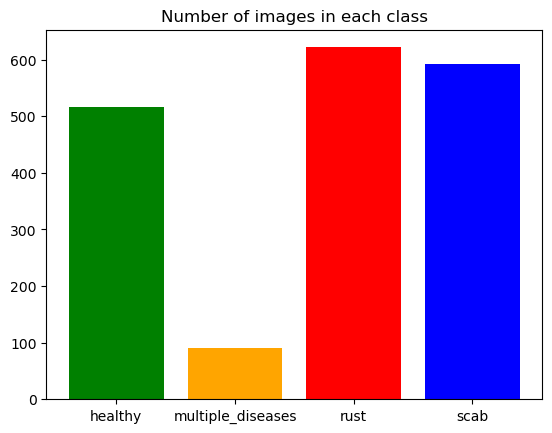

In [23]:
# count each class
healthy = np.sum(train['healthy'])
multiple_diseases = np.sum(train['multiple_diseases'])
rust = np.sum(train['rust'])
scab = np.sum(train['scab'])

# plot
plt.bar(['healthy', 'multiple_diseases', 'rust', 'scab'], [healthy, multiple_diseases, rust, scab])
plt.bar(['healthy', 'multiple_diseases', 'rust', 'scab'], [healthy, multiple_diseases, rust, scab], color=['green', 'orange', 'red', 'blue'])
plt.title('Number of images in each class')
plt.show()

In [25]:
test.head()

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

In [26]:
sample_submission.head()

image_id  healthy  multiple_diseases  rust  scab
0   Test_0     0.25               0.25  0.25  0.25
1   Test_1     0.25               0.25  0.25  0.25
2   Test_2     0.25               0.25  0.25  0.25
3   Test_3     0.25               0.25  0.25  0.25
4   Test_4     0.25               0.25  0.25  0.25

In [27]:
# Load images
def load_image(image_name):
    image_name = image_name + ".jpg"
    image_path = os.path.join(IMAGE_PATH, image_name)
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [28]:
def show_image(image_name, i):
    fig, ax = plt.subplots(figsize=(4, 3))

    img = PILImage.open(IMAGE_PATH + image_name + '.jpg')
    ax.imshow(img)

    label = ' '.join(train.columns[train.iloc[i].values == 1])
    ax.set_title(f'Plant with {label}')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

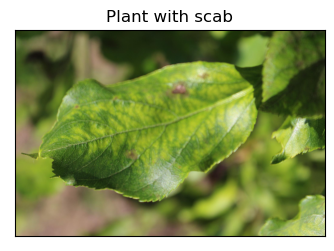

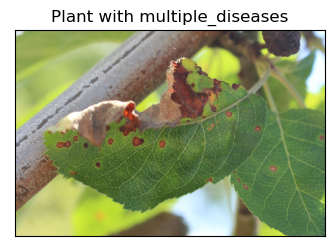

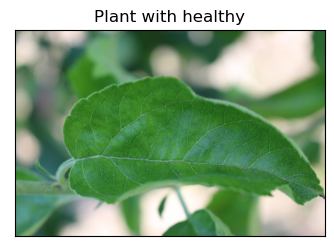

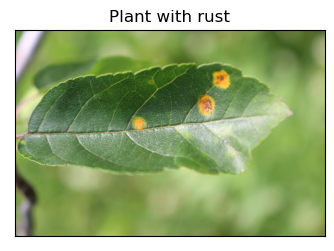

In [29]:
for i in range(4):
    show_image(train.iloc[i]['image_id'], i)

# Data Preprocessing

In [30]:
img = load_image(train.iloc[0]['image_id'])

# Histogram Equalization
def histogram_equalization(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to the Y channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])

    # Convert the image back to RGB format
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

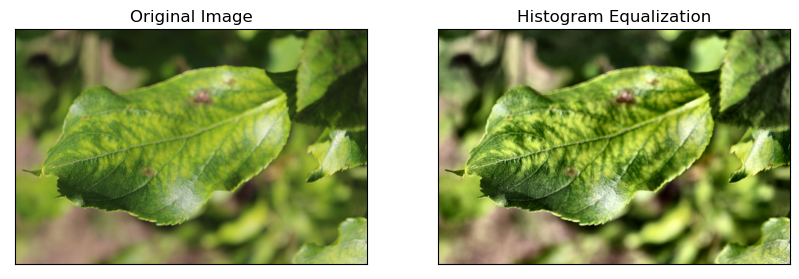

In [31]:
preprocessed_img = histogram_equalization(img)

# Show histogram equalization comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img)
ax[0].set_title('Original Image')

ax[1].imshow(preprocessed_img)
ax[1].set_title('Histogram Equalization')

for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
plt.show()


In [32]:
def init_grabcut_mask(h, w):
    mask = np.ones((h, w), np.uint8) * cv2.GC_PR_BGD
    mask[h//4:3*h//4, w//4:3*w//4] = cv2.GC_PR_FGD
    mask[2*h//5:3*h//5, 2*w//5:3*w//5] = cv2.GC_FGD
    return mask



def add_contours(image, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if len(contours) != 0:
        cv2.drawContours(image, contours, -1, (255, 0, 0), 3)
        c = max(contours, key = cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0) ,2)
    


def remove_background(image):
    h, w = image.shape[:2]
    mask = init_grabcut_mask(h, w)
    bgm = np.zeros((1, 65), np.float64)
    fgm = np.zeros((1, 65), np.float64)
    cv2.grabCut(image, mask, None, bgm, fgm, 1, cv2.GC_INIT_WITH_MASK)
    mask_binary = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    result = cv2.bitwise_and(image, image, mask = mask_binary)
    # add_contours(result, mask_binary) # optional, adds visualizations
    return result


def preprocess_image(image):
    image = histogram_equalization(image)
    image = remove_background(image)
    return image

In [33]:
img = load_image(train.iloc[0]['image_id'])
# resize image
img = cv2.resize(img, (682, 455))
preprocessed_img = preprocess_image(img)

# Show preprocessing comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img)
ax[0].set_title('Original Image')

ax[1].imshow(preprocessed_img)
ax[1].set_title('Preprocessed Image')

for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])

plt.show()

KeyboardInterrupt: 

# Save Segmented Image (Optional)
Data hasil segmentasi gambar sudah disediakan melalui tautan [Github](https://github.com/hadhaz/tugas_pp)

In [34]:
output_directory = './data/preprocessed_images/'

In [ ]:

os.makedirs(output_directory + "train", exist_ok=True)
os.makedirs(output_directory + "test", exist_ok=True)

# Preprocess all images
def preprocess_images(df, category):
    for i in range(len(df)):
        image = load_image(df.iloc[i]['image_id'])
        # resize image
        image = cv2.resize(image, (682, 455))
        image = preprocess_image(image)

        # save image
        cv2.imwrite(f'{output_directory}{category}/{df.iloc[i]["image_id"]}.jpg', image)

preprocess_images(train, "train")
preprocess_images(test, "test")

# Data Augmentation (Optional)

In [105]:
from keras.preprocessing.image import ImageDataGenerator

# Augment class for df["multiple_diseases"] = 1 using datagen
def augment_multiple_diseases(df):
    datagen = ImageDataGenerator(
        rotation_range=360,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    for i in range(len(df)):
        if df.iloc[i]['multiple_diseases'] == 1:
            image = load_image(df.iloc[i]['image_id'])
            # resize image
            image = cv2.resize(image, (682, 455))
            image = preprocess_image(image)
            image = image.reshape((1,) + image.shape)

            j = 0
            for batch in datagen.flow(image, batch_size=1, save_to_dir='./data/augmented/' + "train", save_prefix=df.iloc[i]['image_id'], save_format='jpg'):
                j += 1
                # label to df and df["multiple_diseases"] = 1
                df = df.append({'image_id': df.iloc[i]['image_id'], 'multiple_diseases': 1}, ignore_index=True)
                if j >= 3:
                    break

augment_multiple_diseases(train)

KeyboardInterrupt: 

# Feature Extraction (Optional)
File CSV sudah disediakan melalui tautan [Github]()

In [115]:

from skimage.feature import greycomatrix, greycoprops
from skimage.feature import local_binary_pattern
from skimage.measure import moments, moments_central, moments_normalized, moments_hu
from skimage.measure import perimeter
from skimage import io, color, img_as_ubyte
from skimage.filters import threshold_otsu
from skimage.morphology import convex_hull_image, disk, binary_erosion, binary_dilation, binary_closing, binary_opening
from skimage.transform import resize
from scipy.stats import kurtosis, skew

def extract_features(image):
    # Convert RGB image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # GLCM
    glcm = greycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=False, normed=True)
    glcm_dissimilarity = greycoprops(glcm, 'dissimilarity')[0, 0]
    glcm_correlation = greycoprops(glcm, 'correlation')[0, 0]
    glcm_contrast = greycoprops(glcm, 'contrast')[0, 0]
    glcm_homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    glcm_ASM = greycoprops(glcm, 'ASM')[0, 0]
    glcm_energy = greycoprops(glcm, 'energy')[0, 0]

    # LBP
    lbp = local_binary_pattern(gray_image, 8, 1, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 8 + 3), range=(0, 8 + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    # RGB
    red = image[:, :, 0]
    green = image[:, :, 1]
    blue = image[:, :, 2]

    red_mean = np.mean(red)
    red_std = np.std(red)
    red_skew = skew(red.reshape(-1))
    red_kurtosis = kurtosis(red.reshape(-1))

    green_mean = np.mean(green)
    green_std = np.std(green)
    green_skew = skew(green.reshape(-1))
    green_kurtosis = kurtosis(green.reshape(-1))

    blue_mean = np.mean(blue)
    blue_std = np.std(blue)
    blue_skew = skew(blue.reshape(-1))
    blue_kurtosis = kurtosis(blue.reshape(-1))

    # HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hue = hsv[:, :, 0]
    saturation = hsv[:, :, 1]
    value = hsv[:, :, 2]

    hue_mean = np.mean(hue)
    hue_std = np.std(hue)
    hue_skew = skew(hue.reshape(-1))
    hue_kurtosis = kurtosis(hue.reshape(-1))

    saturation_mean = np.mean(saturation)

    value_mean = np.mean(value)
    value_std = np.std(value)
    value_skew = skew(value.reshape(-1))
    value_kurtosis = kurtosis(value.reshape(-1))

    # Hu Moments and centroid
    moments = cv2.moments(gray_image)
    huMoments = cv2.HuMoments(moments)
    centroid = (moments["m10"] / moments["m00"], moments["m01"] / moments["m00"])

    return [glcm_dissimilarity, glcm_correlation, glcm_contrast, glcm_homogeneity, glcm_ASM, glcm_energy,
            hist[0], hist[1], hist[2], hist[3], hist[4], hist[5], hist[6], hist[7],
            red_mean, red_std, red_skew, red_kurtosis,
            green_mean, green_std, green_skew, green_kurtosis,
            blue_mean, blue_std, blue_skew, blue_kurtosis,
            hue_mean, hue_std, hue_skew, hue_kurtosis,
            saturation_mean,
            value_mean, value_std, value_skew, value_kurtosis,
            huMoments[0][0], huMoments[1][0], huMoments[2][0], huMoments[3][0], huMoments[4][0], huMoments[5][0], huMoments[6][0],
            centroid[0], centroid[1]
            ]

# Extract features for all images
def extract_features_all(df, category):
    features = []
    for i in range(len(df)):
        image = cv2.imread(f'{output_directory}{category}/{df.iloc[i]["image_id"]}.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (682, 455))
        image = preprocess_image(image)

        features.append(extract_features(image))

    return features

train_features = extract_features_all(train, "train")
test_features = extract_features_all(test, "test")

# Save features to csv
train_features_df = pd.DataFrame(train_features, columns=['glcm_dissimilarity', 'glcm_correlation', 'glcm_contrast', 'glcm_homogeneity', 'glcm_ASM', 'glcm_energy',
                                                            'lbp_0', 'lbp_1', 'lbp_2', 'lbp_3', 'lbp_4', 'lbp_5', 'lbp_6', 'lbp_7',
                                                            'red_mean', 'red_std', 'red_skew', 'red_kurtosis',
                                                            'green_mean', 'green_std', 'green_skew', 'green_kurtosis',
                                                            'blue_mean', 'blue_std', 'blue_skew', 'blue_kurtosis',
                                                            'hue_mean', 'hue_std', 'hue_skew', 'hue_kurtosis',
                                                            'saturation_mean',
                                                            'value_mean', 'value_std', 'value_skew', 'value_kurtosis',
                                                            'huMoments_0', 'huMoments_1', 'huMoments_2', 'huMoments_3', 'huMoments_4', 'huMoments_5', 'huMoments_6',
                                                            'centroid_0', 'centroid_1'])

train_features_df.to_csv(f'{output_directory}train_features.csv', index=False)

test_features_df = pd.DataFrame(test_features, columns=['glcm_dissimilarity', 'glcm_correlation', 'glcm_contrast', 'glcm_homogeneity', 'glcm_ASM', 'glcm_energy',
                                                            'lbp_0', 'lbp_1', 'lbp_2', 'lbp_3', 'lbp_4', 'lbp_5', 'lbp_6', 'lbp_7',
                                                            'red_mean', 'red_std', 'red_skew', 'red_kurtosis',
                                                            'green_mean', 'green_std', 'green_skew', 'green_kurtosis',
                                                            'blue_mean', 'blue_std', 'blue_skew', 'blue_kurtosis',
                                                            'hue_mean', 'hue_std', 'hue_skew', 'hue_kurtosis',
                                                            'saturation_mean',
                                                            'value_mean', 'value_std', 'value_skew', 'value_kurtosis',
                                                            'huMoments_0', 'huMoments_1', 'huMoments_2', 'huMoments_3', 'huMoments_4', 'huMoments_5', 'huMoments_6',
                                                            'centroid_0', 'centroid_1'])

test_features_df.to_csv(f'{output_directory}test_features.csv', index=False)


/home/hadzami/anaconda3/envs/cv-tfhub/lib/python3.7/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/home/hadzami/anaconda3/envs/cv-tfhub/lib/python3.7/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/hadzami/anaconda3/envs/cv-tfhub/lib/python3.7/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/hadzami/anaconda3/envs/cv-tfhub/lib/python3.7/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimag

# Feature & Model Selection
## Prepocessing using Standard Scaler

In [47]:
# import classification report
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn import metrics


# select features
features = ['glcm_dissimilarity', 'glcm_correlation', 'glcm_contrast', 'glcm_homogeneity', 'glcm_ASM', 'glcm_energy',
            'lbp_0', 'lbp_1', 'lbp_2', 'lbp_3', 'lbp_4', 'lbp_5', 'lbp_6', 'lbp_7',
            'red_mean', 'red_std', 'red_skew', 'red_kurtosis',
            'green_mean', 'green_std', 'green_skew', 'green_kurtosis',
            'blue_mean', 'blue_std', 'blue_skew', 'blue_kurtosis',
            'hue_mean', 'hue_std', 'hue_skew', 'hue_kurtosis',
            'saturation_mean',
            'value_mean', 'value_std', 'value_skew', 'value_kurtosis',
            'huMoments_0', 'huMoments_1', 'huMoments_2', 'huMoments_3', 'huMoments_4', 'huMoments_5', 'huMoments_6',
            'centroid_0', 'centroid_1']

# Load data
train_features_df = pd.read_csv(f'{output_directory}train_features.csv')
test_features_df = pd.read_csv(f'{output_directory}test_features.csv')

In [49]:
train_features_df

glcm_dissimilarity  glcm_correlation  glcm_contrast  glcm_homogeneity  \
0               4.269746          0.981732     176.520289          0.727605   
1               7.236572          0.933081     494.654848          0.770803   
2               7.914069          0.944667     437.183889          0.701132   
3               7.166020          0.956921     371.364596          0.705398   
4               6.155582          0.945147     398.504939          0.797450   
...                  ...               ...            ...               ...   
1816            7.908435          0.961108     415.253677          0.668934   
1817           13.512988          0.913682     868.936183          0.568660   
1818           10.012787          0.924444     639.660022          0.660310   
1819           10.691081          0.946665     608.868829          0.601733   
1820            5.479734          0.978438     215.554659          0.687105   

      glcm_ASM  glcm_energy     lbp_0     lbp_1     lbp_2     lbp_3  ...  \
0     0.478011     0.691383  0.014946  0.018788  0.021343  0.045841  ...   
1     0.571464     0.755953  0.022300  0.023025  0.013296  0.020892  ...   
2     0.461450     0.679301  0.030905  0.032448  0.020096  0.026100  ...   
3     0.464761     0.681734  0.026780  0.029522  0.021495  0.031639  ...   
4     0.611817     0.782187  0.020654  0.021485  0.012935  0.019091  ...   
...        ...          ...       ...       ...       ...       ...  ...   
1816  0.410476     0.640684  0.023889  0.028700  0.023821  0.043154  ...   
1817  0.294874     0.543023  0.049512  0.048716  0.025990  0.030292  ...   
1818  0.404046     0.635646  0.017850  0.029677  0.022307  0.047707  ...   
1819  0.329758     0.574245  0.036190  0.037314  0.028356  0.044739  ...   
1820  0.424995     0.651916  0.017914  0.023286  0.026425  0.049544  ...   

      value_kurtosis  huMoments_0   huMoments_1   huMoments_2   huMoments_3  \
0           0.146086     0.001500  5.314447e-07  2.409534e-10  9.619537e-12   
1           1.864672     0.001505  3.281929e-07  2.341125e-10  2.002321e-11   
2           0.132542     0.001839  1.518068e-06  9.154595e-10  1.447057e-10   
3           0.841058     0.001847  1.654497e-06  2.397618e-10  2.871801e-11   
4           2.178735     0.003132  8.247342e-06  5.592805e-10  5.488709e-11   
...              ...          ...           ...           ...           ...   
1816        0.153546     0.001566  6.073362e-07  1.044169e-10  1.422716e-11   
1817       -0.682744     0.001856  9.673434e-07  2.010514e-09  1.611041e-10   
1818        0.213772     0.001692  6.937748e-07  5.156449e-10  5.874118e-11   
1819       -0.514578     0.002304  3.001990e-06  9.634740e-10  7.560934e-10   
1820       -0.095096     0.001530  7.371003e-07  2.490459e-11  4.360858e-12   

       huMoments_4   huMoments_5   huMoments_6  centroid_0  centroid_1  
0     4.111236e-22  2.947733e-15 -2.132175e-22  312.674204  209.063870  
1    -1.982907e-22 -4.398847e-15 -1.356506e-21  320.939578  233.302253  
2     3.802687e-20  1.028158e-13 -3.644022e-20  340.974721  248.023170  
3     2.211572e-21  3.532565e-14 -8.874518e-22  280.528046  203.921512  
4    -9.294350e-21 -1.532907e-13 -2.468491e-21  344.370073  231.702450  
...            ...           ...           ...         ...         ...  
1816  5.436241e-22  9.548117e-15  7.188139e-23  306.138564  221.006356  
1817  2.472857e-20 -9.008322e-15  8.829056e-20  278.649802  172.399478  
1818  9.025742e-21  4.815805e-14 -4.801144e-21  361.165656  211.010745  
1819  6.436592e-19  1.072449e-12 -4.643337e-20  328.244419  207.466265  
1820  4.166955e-23  3.649742e-15  1.813852e-23  402.286127  205.947673  

[1821 rows x 44 columns]

In [50]:
from sklearn.preprocessing import StandardScaler

# preoceesing using standard scaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features_df[features])
test_features = scaler.transform(test_features_df[features])

In [57]:
# train test split
from sklearn.model_selection import train_test_split

labels = train[['healthy', 'multiple_diseases', 'rust', 'scab']]

# convert labels to 1D array
labels = np.argmax(np.array(labels), axis=1)

X_train, X_test, y_train, y_test = train_test_split(train_features, labels, test_size=0.2, random_state=42)

# SVM
svm = SVC(kernel='rbf', C=1, gamma=0.1)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5287671232876713
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       100
           1       0.00      0.00      0.00        18
           2       0.46      0.57      0.51       120
           3       0.58      0.51      0.54       127

    accuracy                           0.53       365
   macro avg       0.40      0.42      0.41       365
weighted avg       0.51      0.53      0.52       365



/home/hadzami/anaconda3/envs/cv-tfhub/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hadzami/anaconda3/envs/cv-tfhub/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hadzami/anaconda3/envs/cv-tfhub/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [58]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5287671232876713
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       100
           1       0.00      0.00      0.00        18
           2       0.47      0.60      0.53       120
           3       0.56      0.55      0.56       127

    accuracy                           0.53       365
   macro avg       0.41      0.42      0.41       365
weighted avg       0.51      0.53      0.52       365



In [59]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Grid Search
# Create a pipeline
pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {'classifier': [SVC()],
                    'classifier__kernel': ['rbf', 'linear'],
                    'classifier__C': [0.1, 1, 10, 100],
                    'classifier__gamma': [0.1, 1, 10, 100]
                },
                {'classifier': [RandomForestClassifier()],
                    'classifier__n_estimators': [10, 100, 1000],
                    'classifier__max_depth': [5, 10, 20, 50, 100]
                },
                {'classifier': [KNeighborsClassifier()],
                    'classifier__n_neighbors': [5, 10, 20, 50, 100]
                },
                {'classifier': [LogisticRegression()],
                    'classifier__penalty': ['l1', 'l2'],
                    'classifier__C': np.logspace(0, 4, 10)
                }
            ]

# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0, n_jobs=-1)  # Fit grid search
best_model = gridsearch.fit(X_train, y_train)

# print best model results
print(best_model.best_estimator_)
print("The mean accuracy of the model is:", best_model.score(X_test, y_test))
print(classification_report(y_test, best_model.predict(X_test)))


Accuracy: 0.43561643835616437
              precision    recall  f1-score   support

           0       0.43      0.50      0.47       100
           1       0.00      0.00      0.00        18
           2       0.40      0.45      0.42       120
           3       0.52      0.43      0.47       127

    accuracy                           0.44       365
   macro avg       0.34      0.35      0.34       365
weighted avg       0.43      0.44      0.43       365

Accuracy: 0.6356164383561644
              precision    recall  f1-score   support

           0       0.60      0.51      0.55       100
           1       0.00      0.00      0.00        18
           2       0.60      0.73      0.66       120
           3       0.69      0.73      0.71       127

    accuracy                           0.64       365
   macro avg       0.47      0.49      0.48       365
weighted avg       0.60      0.64      0.62       365



/home/hadzami/anaconda3/envs/cv-tfhub/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/hadzami/anaconda3/envs/cv-tfhub/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hadzami/anaconda3/envs/cv-tfhub/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: U

Pipeline(steps=[('classifier', SVC(C=100, gamma=0.1, kernel='linear'))])
The mean accuracy of the model is: 0.6383561643835617
              precision    recall  f1-score   support

           0       0.56      0.52      0.54       100
           1       0.00      0.00      0.00        18
           2       0.63      0.78      0.70       120
           3       0.71      0.69      0.70       127

    accuracy                           0.64       365
   macro avg       0.47      0.50      0.48       365
weighted avg       0.61      0.64      0.62       365



/home/hadzami/anaconda3/envs/cv-tfhub/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hadzami/anaconda3/envs/cv-tfhub/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hadzami/anaconda3/envs/cv-tfhub/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

[0.02252319 0.02501526 0.02397765 0.02074663 0.0208555  0.02030376
 0.02615799 0.02515349 0.02258293 0.02229294 0.02111461 0.02265713
 0.02344764 0.02129149 0.02354941 0.0230193  0.02248569 0.02271441
 0.01804011 0.02472586 0.01951847 0.02021639 0.02299519 0.03101898
 0.02683334 0.03433746 0.02174546 0.03359792 0.02062725 0.0218917
 0.02213578 0.01965435 0.0245685  0.02032855 0.01941758 0.02810311
 0.0247396  0.01996383 0.01834032 0.01750714 0.01692367 0.01756426
 0.02309446 0.02222173]


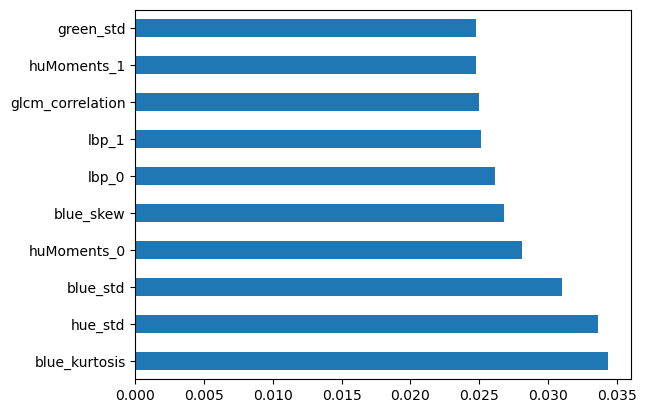

In [64]:
# Show visualization to select best features
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(train_features, labels)
print(model.feature_importances_)  # use inbuilt class feature_importances of tree based classifiers
# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=train_features_df[features].columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()